In [1]:
import h5py
import pandas as pd
import numpy as np
import matplotlib
import seaborn
import matplotlib.dates as md
import keras
import tensorflow as tf
from matplotlib import pyplot as plt
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from keras.layers.core import Dense, Activation, Dropout, Flatten
from keras.layers import Embedding,GlobalMaxPooling1D, SpatialDropout1D
from keras.layers.recurrent import LSTM
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint
import time
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import BatchNormalization

In [2]:
#Reading the H5 file
filename = "sensors_data_augmented.h5"
h5f = h5py.File(filename,'r')
sensors_data = h5f['dataset_1'][:]
h5f.close()
#The H5 file contains also the information of a temperature sensor, that you can discard
sensors_data_final = sensors_data[:,[1,2,3,4,5,6],:]#Not using temperature 
with open('binary_labels_augmented.txt') as f:
    lines = f.readlines()
X = sensors_data_final
#print(X.shape)
#X = np.reshape(X,(420, 300, 6))
#print(X.shape)
y = lines
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y = le.fit_transform(y)
df = pd.DataFrame([list(l) for l in X]).stack().apply(pd.Series).reset_index(1, drop=True)
df.index.name = 'Date'
df.columns = [str(i) for i in range(1,301)]
df_180 = df[[str(i) for i in range(1,181)]]
print(df_180)
x = []
for i in range(len(X)):
    x.append(df_180.loc[i].to_numpy())
X = x
X = np.array(X)
X.shape
binary_labels_augmented = np.array(y)
print(binary_labels_augmented.shape)
binary_labels_augmented = np.reshape(binary_labels_augmented,(420, 1))
print(binary_labels_augmented.shape)

        1    2     3     4     5      6  ...   175   176   177   178   179   180
Date                                     ...                                    
0     4.0  0.0   0.0   3.0   4.0    3.0  ...  28.0  29.0  28.0  27.0  28.0  28.0
0     4.0  1.0   0.0   3.0   3.0    1.0  ...  22.0  22.0  21.0  22.0  22.0  23.0
0     5.0  0.0   0.0   4.0   4.0    0.0  ...   1.0   1.0   1.0   0.0   2.0   3.0
0     0.0  1.0  15.0  47.0  83.0  116.0  ...  70.0  71.0  69.0  69.0  69.0  68.0
0     5.0  0.0   0.0   4.0   4.0    0.0  ...   5.0   5.0   4.0   4.0   5.0   5.0
...   ...  ...   ...   ...   ...    ...  ...   ...   ...   ...   ...   ...   ...
419   0.0  0.0   0.0   0.0   0.0    0.0  ...   4.9   4.8   4.7   4.6   4.6   4.6
419   0.0  0.0   0.0   0.0   0.0    0.0  ...   2.2   2.2   2.1   2.1   2.0   2.0
419   0.0  0.0   0.0   0.0   0.0    0.0  ...  35.9  35.7  35.4  35.1  34.9  34.7
419   0.0  0.0   0.0   0.0   0.0    0.0  ...   3.1   3.1   3.1   3.1   3.0   3.1
419   0.0  0.0   0.0   0.0  

In [3]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
for i in range(len(X)):
    X[i] = sc.fit_transform(X[i])
from sklearn import preprocessing
for i in range(len(X)):
    X[i] = preprocessing.normalize(X[i])
X_train = X[:337,:]
X_test = X[:337,:]
y_train = binary_labels_augmented[:337,:]
y_test = binary_labels_augmented[:337,:]

In [ ]:
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.optimizers import Adam
opt = Adam(learning_rate=0.0005)
def build_classifier(optimizer):
  model = Sequential()
  model.add(LSTM(
            20,
            input_shape=[X_train.shape[1], X_train.shape[2]],
            recurrent_dropout = 0.3,
            return_sequences=True
            )
  )
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(LSTM(30,
                recurrent_dropout = 0.3
                )
  )
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  #model.add(Flatten())
  model.add(Dropout(0.1))
  model.add(Dense(120, activation='relu'))
  model.add(Dropout(0.1))
  model.add(Dense(84, activation='relu'))
  model.add(Dense(y_train.shape[1], activation='sigmoid'))
  from tensorflow.keras.optimizers import Adam
  opt = Adam(learning_rate=0.005)
  model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
  return model
model = KerasClassifier(build_fn=build_classifier)
parameters = {'batch_size' : [10,20,30,40,50],
              'epochs' : [100,200,300,400,500],
            #  'learning_rate' :[0.1,0.01,0.001,0.0001,0.0005],
              'optimizer' : ['adam','Adadelta',opt] }

grid_search  = GridSearchCV(estimator = model,
                            param_grid = parameters,
                            scoring = 'accuracy',
                            cv = 2)
grid_result = grid_search.fit(X, y)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
Epoch 439/500
5/5 [==============================] - 0s 42ms/step - loss: 0.0254 - accuracy: 1.0000
Epoch 440/500
5/5 [==============================] - 0s 37ms/step - loss: 0.0312 - accuracy: 0.9857
Epoch 441/500
5/5 [==============================] - 0s 39ms/step - loss: 0.0309 - accuracy: 0.9857
Epoch 442/500
5/5 [==============================] - 0s 41ms/step - loss: 0.0286 - accuracy: 0.9857
Epoch 443/500
5/5 [==============================] - 0s 36ms/step - loss: 0.0112 - accuracy: 0.9952
Epoch 444/500
5/5 [==============================] - 0s 37ms/step - loss: 0.0226 - accuracy: 0.9905
Epoch 445/500
5/5 [==============================] - 0s 36ms/step - loss: 0.0174 - accuracy: 0.9952
Epoch 446/500
5/5 [==============================] - 0s 35ms/step - loss: 0.0122 - accuracy: 0.9952
Epoch 447/500
5/5 [==============================] - 0s 38ms/step - loss: 0.0547 - accuracy: 0.9905
Epoch 448/500
5/5 [===

In [4]:
model = Sequential()
model.add(LSTM(
          20,
          input_shape=[X_train.shape[1], X_train.shape[2]],
          recurrent_dropout = 0.2,
          return_sequences=True
          )
)
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(LSTM(30,
               recurrent_dropout = 0.2
               )
)
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dense(120, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(84, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(y_train.shape[1], activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='Adam', metrics=['accuracy'])
print(model.summary())
hist = model.fit(X_train,
                 y_train,
                 batch_size = 50,
                 epochs=500,
                 validation_data=(X_test, y_test),
                 shuffle = True,
                 callbacks = [ModelCheckpoint("model.hdf5",
                              monitor = 'val_accuracy',
                              save_best_only = True,
                              save_weights_only = False,
                              save_freq= 'epoch')])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 6, 20)             16080     
_________________________________________________________________
batch_normalization (BatchNo (None, 6, 20)             80        
_________________________________________________________________
activation (Activation)      (None, 6, 20)             0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 30)                6120      
_________________________________________________________________
batch_normalization_1 (Batch (None, 30)                120       
_________________________________________________________________
activation_1 (Activation)    (None, 30)                0         
_________________________________________________________________
dense (Dense)                (None, 120)               3

In [5]:
from keras.models import load_model
model.load_weights('model.hdf5')
model.evaluate(X_test, y_test)

11/11 [==============================] - 0s 3ms/step - loss: 0.0381 - accuracy: 0.9881


[0.038085345178842545, 0.9881305694580078]

Confusion Matrix
Classification Report
              precision    recall  f1-score   support

           0       1.00      0.98      0.99       193
           1       0.97      1.00      0.99       144

    accuracy                           0.99       337
   macro avg       0.99      0.99      0.99       337
weighted avg       0.99      0.99      0.99       337



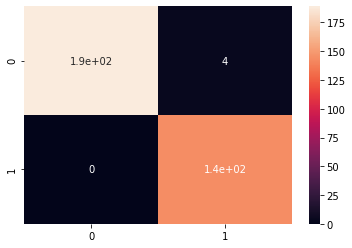

In [8]:
from sklearn.metrics import confusion_matrix, classification_report
y_pred=[]
model.load_weights('model.hdf5')
Y_pred = model.predict(X_test)
#print(Y_pred)
for elt in Y_pred:
  if elt < 0.5 : 
    y_pred.append(0)
  else:
    y_pred.append(1)
#print(Y_pred)
print('Confusion Matrix')
cm = confusion_matrix(y_test, y_pred)
import seaborn as sns
sns.heatmap(cm, annot=True)
print('Classification Report')
class_labels = y_test 
report = classification_report(y_test, y_pred)
print(report) 

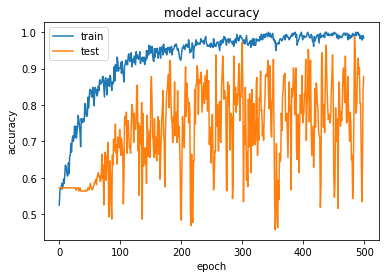

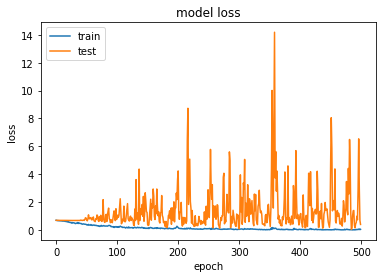

In [7]:
# summarize history for accuracy
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()